# <b><font color="pink"> HiFi-GAN Fine-Tuning
<b><font color="white"> To train a fine-tuned HiFi-GAN model, run the cells below and follow the instructions.

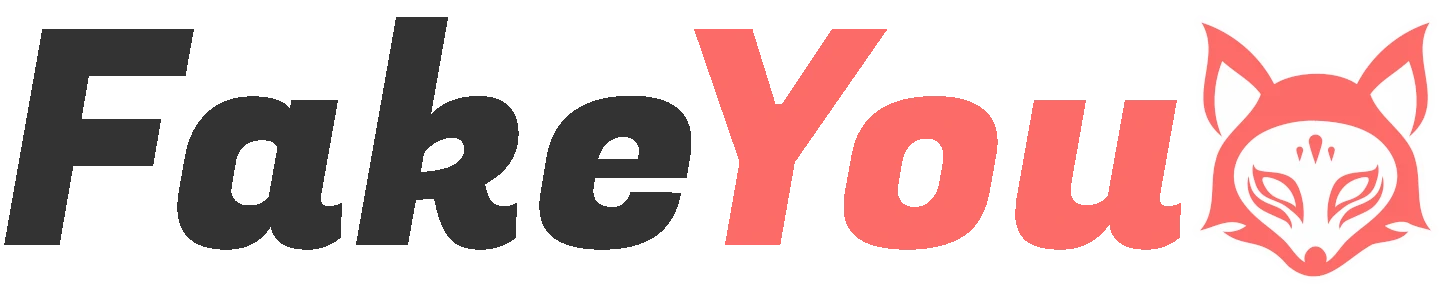
### [FakeYou](https://fakeyou.com/)
---

#### Special thanks to Cookie from the Pony Preservation Project
###### Slight modifications and fixes by justinjohn-03

In [ ]:
#@markdown <b><font color="pink">Step 1: Check which GPU you've been allocated.

#@markdown You want a P100, V100 or T4. 
#@markdown If you get a P4 or K80, factory reset the runtime and try again.
!nvidia-smi -L
!nvidia-smi

In [ ]:
#@markdown <b><font color="pink"> Step 2: Mount Google Drive.
from google.colab import drive
drive.mount('drive')

In [ ]:
#@markdown <b><font color="pink"> Step 3: Configure training data paths. Upload the following to your Drive and change the paths below:
#@markdown * A fully trained 22KHz Tacotron model ([training notebook here](https://colab.research.google.com/github/justinjohn0306/FakeYou-Tacotron2-Notebook/blob/main/FakeYou_Tacotron_2_(w_ARPAbet)_Training.ipynb))
#@markdown * The dataset it was trained on, packaged as a .zip or .tar file
#@markdown * The training and validation filelists used
tacotron_model = "/content/drive/My Drive/path_to_tacotron" #@param {type:"string"}
tacotron_dataset = "/content/drive/My Drive/path_to_dataset.zip" #@param {type:"string"}
train_filelist = "/content/drive/My Drive/train_filelist.txt" #@param {type:"string"}
val_filelist = "/content/drive/My Drive/val_filelist.txt" #@param {type:"string"}
print("OK")


In [ ]:
#@markdown <b><font color="pink"> Step 4: Download Tacotron and HiFi-GAN.
import os
!pip install -q torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 torchtext==0.14.1 torchdata==0.5.1 --extra-index-url https://download.pytorch.org/whl/cu117 -U
!pip install git+https://github.com/wkentaro/gdown.git
!git clone -q https://github.com/justinjohn0306/TTS-TT2.git
os.chdir('/content/TTS-TT2')
!git submodule init
!git submodule update
os.chdir('/content')
!git clone -q https://github.com/SortAnon/hifi-gan.git
!pip install -q unidecode librosa==0.9.1 tensorboardX

In [ ]:
#@markdown <b><font color="pink"> Step 5: Generate ground truth-aligned spectrograms. This will help HiFi-GAN learn what your Tacotron model sounds like.

#@markdown If this step fails, try the following:
#@markdown * Go back to step 3, correct the paths and run that cell again.
#@markdown * Make sure your filelists are correct. They should have relative paths starting with "wavs/".

import os
import shutil
os.chdir('/content/TTS-TT2')
if os.path.exists("/content/TTS-TT2/wavs"):
    shutil.rmtree("/content/TTS-TT2/wavs")
os.mkdir("wavs")
os.chdir("wavs")
if tacotron_dataset[-4:] == ".zip":
    !unzip -q "{tacotron_dataset}"
elif tacotron_dataset[-4:] == ".tar":
    !tar -xf "{tacotron_dataset}"
else:
    raise Exception("Unknown extension for tacotron_dataset")
if os.path.exists("/content/TTS-TT2/wavs/wavs"):
    shutil.move("/content/TTS-TT2/wavs/wavs", "/content/TTS-TT2/tempwavs")
    shutil.rmtree("/content/TTS-TT2/wavs")
    shutil.move("/content/TTS-TT2/tempwavs", "/content/TTS-TT2/wavs")

os.chdir('/content/TTS-TT2')
shutil.copyfile(tacotron_model, "/content/TTS-TT2/tacomodel")
seen_files = []
with open(train_filelist) as f:
    taco_filelist = f.readlines()
with open(val_filelist) as f:
    taco_filelist.extend(f.readlines())
with open("/content/TTS-TT2/filelists/ljs_audio_text_train_filelist.txt", "w") as f:
    for x in taco_filelist:
        if x.split("|")[0] not in seen_files:
            seen_files.append(x.split("|")[0])
            f.write(x)
if os.path.exists("/content/TTS-TT2/GTAOutput"):
    shutil.rmtree("/content/TTS-TT2/GTAOutput")
os.mkdir("GTAOutput")
!python GTA.py -c tacomodel -o GTAOutput

In [ ]:
#@markdown <b><font color="pink"> Step 6: Train HiFi-GAN. 5,000+ steps are recommended. Stop this cell to finish training the model.

#@markdown The checkpoints are saved to the path configured below. If an existing checkpoint is found,
#@markdown the notebook will resume training from it. Otherwise, it'll start from a universal model.

#@markdown When done, generate a Drive share link for the "g_00000000" file, with permissions set to "Anyone with the link". 
#@markdown Save a copy of the [inference notebook](https://colab.research.google.com/github/justinjohn0306/FakeYou-Tacotron2-Notebook/blob/main/FakeYou_Tacotron2_Hi_Fi_GAN_(CPU).ipynb),
#@markdown add a new character entry to it, and use that file as your HIFIGAN_ID.

output_dir = "/content/drive/My Drive/hifimodels/name_of_character"  #@param {type:"string"}
checkpoint_interval = 250 #@param {type:"integer"}

import gdown
d = 'https://drive.google.com/uc?id='

os.chdir('/content/hifi-gan')
if os.path.exists("/content/hifi-gan/ft_dataset"):
    shutil.rmtree("/content/hifi-gan/ft_dataset")
shutil.copytree("/content/TTS-TT2/GTAOutput/mels/", "/content/hifi-gan/ft_dataset/wavs/")
if os.path.exists("/content/hifi-gan/wavs"):
    shutil.rmtree("/content/hifi-gan/wavs")
shutil.copytree("/content/TTS-TT2/wavs/", "/content/hifi-gan/wavs/")
shutil.copyfile(train_filelist, "/content/hifi-gan/training.txt")
shutil.copyfile(val_filelist, "/content/hifi-gan/validation.txt")

if not os.path.exists("/content/drive/My Drive"):
    raise Exception("Cannot find Google Drive")
if "/content/drive/My Drive" not in output_dir:
    print("Warning: Output directory does not seem to be in Google Drive!")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(os.path.join(output_dir, "do_00000000")):
    print("Downloading universal model...")
    gdown.download(d+"1O63eHZR9t1haCdRHQcEgMfMNxiOciSru", os.path.join(output_dir, "do_00000000"), quiet=False)
    gdown.download(d+"1qpgI41wNXFcH-iKq1Y42JlBC9j0je8PW", os.path.join(output_dir, "g_00000000"), quiet=False)
    start_from_universal = "--warm_start True "
else:
    start_from_universal = ""

!python train.py --fine_tuning True --config config_v1b.json \
{start_from_universal}\
--checkpoint_interval {checkpoint_interval} --checkpoint_path "{output_dir}" \
--input_training_file "/content/hifi-gan/training.txt" \
--input_validation_file "/content/hifi-gan/validation.txt" \
--input_wavs_dir "" --input_mels_dir "ft_dataset"


